В данном нубуке, буду разбирать по крупицам проекты с карьерного цеха

# Задание 1

HeadHunter - популярнейший сервис по поиску работы соискателем, а также поиска сотрудников работодателями.

Один из ключевых элементов сервиса — поисковое ядро, которое по запросу пользователя подбирает ему отранжированный список вакансий.  Пользователь может перейти в каждую вакансию на странице поисковой выдачи (SERP) и откликнуться на неё.

Мы в HeadHunter решили не отставать от времени и внедрить современные решения. У каждой вакансии на serp’е отображается краткое описание и логотип, который указывает компания-работодателя. Мы хотим попробовать заменить описание и логотип на автоматически сгенерированные с помощью нейронных сетей (типа ChatGPT и Midjourney), тем самым повысив привлекательность вакансии и увеличить количество откликов на нее.

Как data-driven компания, мы не запустим такую функцию без тестирования и выкатим её через A/B-тест.

**Ваша задача** — выбрать методологию и дизайн такого теста. Для этого нужно определить объект тестирования и принцип разделения на группы, а также рассчитать, какой эффект мы сможем статистически значимо отследить.

**В качестве целевой метрики в А/В используйте долю вакансий, у которых данный скор меньше определенного числа (пусть будет 3).**

Нужно учесть, что наш поиск — умный, и в алгоритме ранжирования в онлайне учитываются просмотры и отклики на каждую вакансию, сделанные за последние несколько дней/часов. Возможно, вам стоить знать, что как и любой поиск, у нас наблюдается position bias.

### Задание

1. Опишите методологию и дизайн теста. Почему сделали такой выбор?
    1. Определите объект тестирования и принцип разделения на группы.
    2. Рассчитайте, какой эффект можно статистически значимо отследить. Укажите его.

#Решение 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1kikgAyfPvMqzwO5u4WP0Jg7xcpJzPWwI

Downloading...
From: https://drive.google.com/uc?id=1kikgAyfPvMqzwO5u4WP0Jg7xcpJzPWwI
To: /content/serps.csv
100% 125M/125M [00:00<00:00, 196MB/s]


In [ ]:
  serp_df = pd.read_csv('serps.csv')

In [ ]:
serp_df

,request_id,vacancy_id_conv,city,applicant
0,168719525526659303f2dee867dc6eda,48019,Moscow,78076
1,168719525526659303f2dee867dc6eda,45120,Moscow,614859
2,168719525526659303f2dee867dc6eda,18132,Moscow,175212
3,168719525526659303f2dee867dc6eda,29942,Moscow,322643
4,168719525526659303f2dee867dc6eda,32658,Moscow,722260
...,...,...,...,...
2431591,16871839548434b4f62891daa5d10fd3,1102,Samara,156365
2431592,1687164459878871f4f0832e5fb53b5f,5170,Samara,615232
2431593,1687153595384444d2da11ecd811f7c4,8001,Samara,478614
2431594,168716903797271e492f2306df102cf8,28428,Samara,901182


In [ ]:
serp_df['request_id'] = serp_df['request_id'].astype('string')
serp_df['vacancy_id_conv'] = serp_df['vacancy_id_conv'].astype('string')
serp_df['applicant'] = serp_df['applicant'].astype('string')

In [ ]:
serp_df

,request_id,vacancy_id_conv,city,applicant
0,168719525526659303f2dee867dc6eda,48019,Moscow,78076
1,168719525526659303f2dee867dc6eda,45120,Moscow,614859
2,168719525526659303f2dee867dc6eda,18132,Moscow,175212
3,168719525526659303f2dee867dc6eda,29942,Moscow,322643
4,168719525526659303f2dee867dc6eda,32658,Moscow,722260
...,...,...,...,...
2431591,16871839548434b4f62891daa5d10fd3,1102,Samara,156365
2431592,1687164459878871f4f0832e5fb53b5f,5170,Samara,615232
2431593,1687153595384444d2da11ecd811f7c4,8001,Samara,478614
2431594,168716903797271e492f2306df102cf8,28428,Samara,901182


In [ ]:
serp_df.describe()

,request_id,vacancy_id_conv,city,applicant
count,2431596,2431596,2431596,2431596
unique,1000000,55500,5,911862
top,1687183190272f07c624a6fe233e56af,13960,Moscow,59921
freq,50,22899,785767,12


In [ ]:
serp_df['city'].value_counts()

Moscow    785767
SPb       592298
Kazan     456466
Penza     347974
Samara    249091
Name: city, dtype: int64

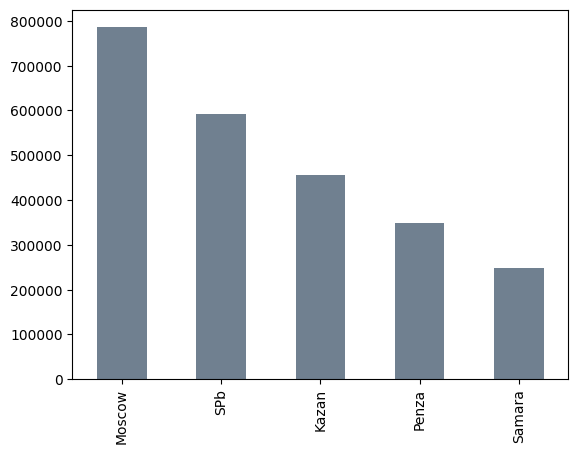

In [ ]:
serp_df['city'].value_counts().plot(kind='bar', color = 'slategrey')
plt.show()

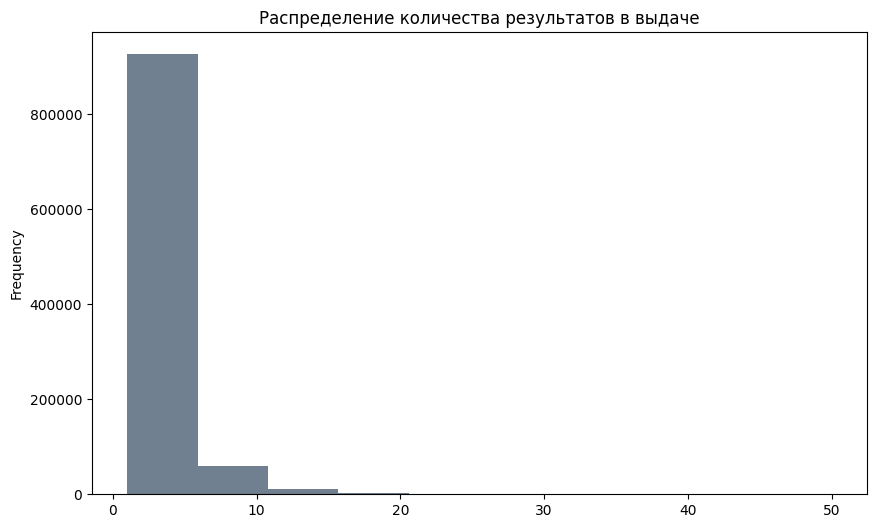

In [ ]:
plt.figure(figsize=(10,6))
serp_df.groupby(['request_id'])['request_id'].agg('count').plot.hist(color='slategrey', title='Распределение количества результатов в выдаче', xlabel='Количество вакансии в выдаче', ylabel='Количество выдач')
plt.show()

In [ ]:
serp_df.groupby(['request_id'])['request_id'].agg('count').describe().to_frame()

,request_id
count,1000000.000000
mean,2.431596
std,2.290122
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,50.000000


Используем метрики

In [ ]:
# для работы в колабе
!gdown https://drive.google.com/uc?id=19Qmn2IyTx7M7R-P1m8yA_OPQ1D1aTyIx

Downloading...
From: https://drive.google.com/uc?id=19Qmn2IyTx7M7R-P1m8yA_OPQ1D1aTyIx
To: /content/vacs_metrics (1).csv
100% 1.60M/1.60M [00:00<00:00, 147MB/s]


In [ ]:
metrics_df = pd.read_csv('vacs_metrics (1).csv')

In [ ]:
metrics_df

,vacancy_id_conv,metric_full,emplpyer_id
0,1,5.250818,640
1,2,5.808587,5123
2,3,2.830297,3325
3,4,5.179469,3511
4,5,5.457955,6604
...,...,...,...
55495,58338,2.825501,1900
55496,58339,0.842977,2173
55497,58342,-0.628653,1110
55498,58343,1.892471,9611


In [ ]:
metrics_df['vacancy_id_conv'] = metrics_df['vacancy_id_conv'].astype('string')
metrics_df['employer_id'] = metrics_df['emplpyer_id'].astype('string')  # заодно переименуем


In [ ]:
metrics_df.drop(['emplpyer_id'], axis=1, inplace=True)

In [ ]:
metrics_df.describe(include='string')

,vacancy_id_conv,employer_id
count,55500,55500
unique,55500,9961
top,1,798
freq,1,18


In [ ]:
metrics_df.describe()

,metric_full
count,55500.000000
mean,4.393625
std,1.430828
min,-2.259488
25%,3.609140
50%,4.562120
75%,5.372227
max,8.949871


**vacancy_id_conv** - колонка валидна, все id уникальны, встречаются строго по одному разу. Дубликатов вакансий нет

**employer_id** - колонка валидна, всего 9961 уникальный работодатель, самый популярный имеет 18 вакансий

**metric_full** - метрика принимает значения от -2.26 до 8.95, среднее значение 4.39

In [ ]:
metrics_df

,vacancy_id_conv,metric_full,employer_id
0,1,5.250818,640
1,2,5.808587,5123
2,3,2.830297,3325
3,4,5.179469,3511
4,5,5.457955,6604
...,...,...,...
55495,58338,2.825501,1900
55496,58339,0.842977,2173
55497,58342,-0.628653,1110
55498,58343,1.892471,9611


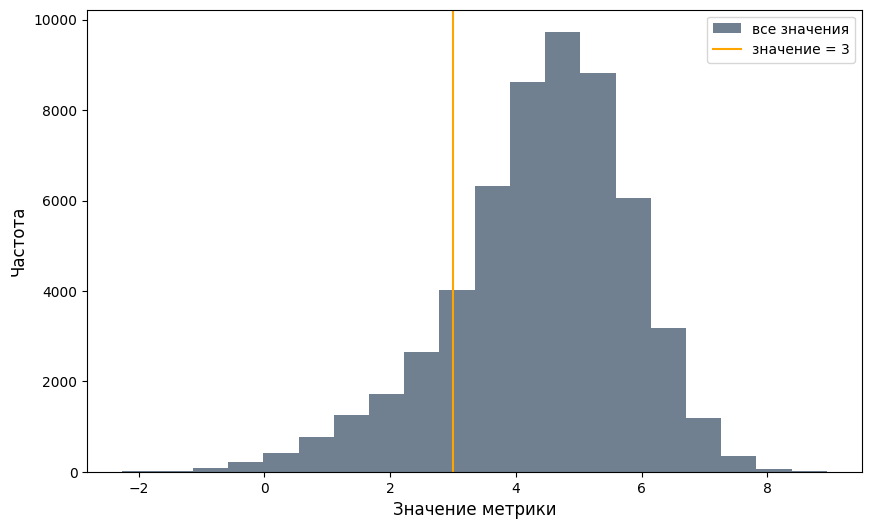

In [ ]:
plt.figure(figsize=(10, 6))
metrics_df['metric_full'].plot.hist(bins=20,color='slategrey', label='все значения')
plt.axvline(x=3, color='orange', label='значение = 3')
plt.xlabel('Значение метрики', fontsize='large')
plt.ylabel('Частота', fontsize='large')
plt.legend()
plt.show()

In [ ]:
print(f"Процент \"плохих\" вакансий: {round(len(metrics_df[metrics_df['metric_full'] < 3]) / len(metrics_df) * 100, 2)}%")
print(f"Процент \"хороших\" вакансий: {round(len(metrics_df[metrics_df['metric_full']>=3]) / len(metrics_df)*100, 2)}%")

Процент "плохих" вакансий: 15.31%
Процент "хороших" вакансий: 84.69%


Проверка данных на нормальность, путем постройки qq plot

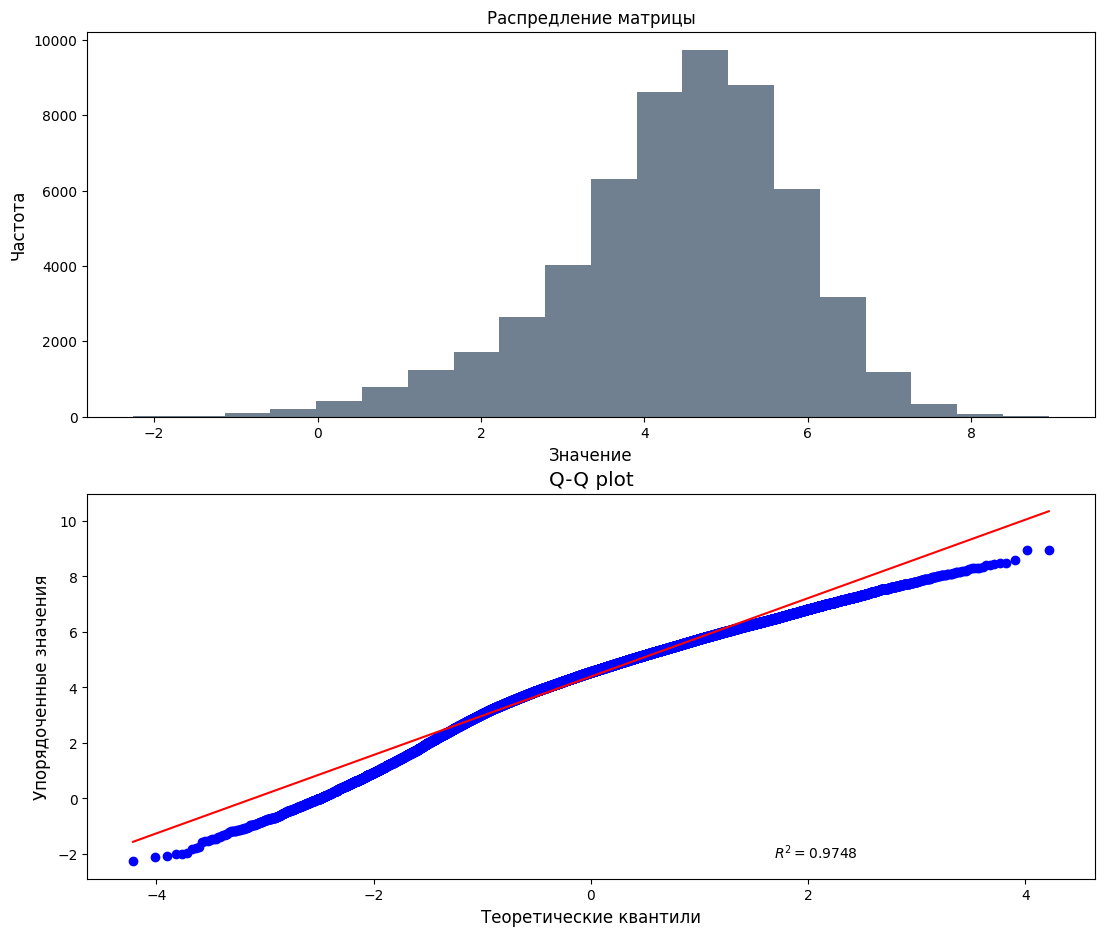

In [ ]:
sample = metrics_df['metric_full']
fig = plt.figure(figsize=(13, 11))
ax=fig.add_subplot(211)
plt.hist(sample, bins=20, color='slategrey')
plt.title('Распредление матрицы', fontsize='large')
plt.ylabel('Частота', fontsize='large')
plt.xlabel('Значение', fontsize='large')
ax2=fig.add_subplot(212)
stats.probplot(sample, dist='norm', plot=plt, fit=True, rvalue=True)
plt.title('Q-Q plot', fontsize='x-large')
plt.ylabel('Упорядоченные значения', fontsize='large')
plt.xlabel('Теоретические квантили', fontsize='large')
plt.show()

In [ ]:
stats.shapiro(sample)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9747732877731323, pvalue=0.0)

Мы получили достаточно хороший результат детерминации и показатели теста Шапиро, чтобы утверждать, что данное данное распредление является нормальным. Перейдем к дизайну AB-теста

In [ ]:
import math
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import NormalIndPower

In [ ]:
alpha = 0.05
power = 0.8

power_analysis = NormalIndPower()


In [ ]:
less_than_3 = metrics_df[metrics_df['metric_full'] < 3]
less_than_3.head(5)

,vacancy_id_conv,metric_full,employer_id
2,3,2.830297,3325
36,37,2.718547,5685
51,52,2.840717,4405
58,59,2.770307,5415
60,61,0.789023,5325


In [ ]:
sample_size = 100 # задаётся менеджером

effect_size = power_analysis.solve_power(nobs1=sample_size, power=power, alpha=alpha, alternative='two-sided')
effect_size

0.39620357647695037

In [ ]:
# переводим MDE в разницу в абсолютных процентах (+5% или -5%)

current_share = len(less_than_3) / len(metrics_df)

min_effect = (math.sin(math.asin(math.sqrt(current_share)) - (effect_size / 2)) ** 2) - current_share
print(round(min_effect, 3)) # в процентах

-0.112


In [ ]:
curren_share = len(less_than_3)/len(metrics_df)
min_effect = -0.112
effect_size = proportion_effectsize(current_share, current_share+min_effect)
effect_size

0.39567188781969626

#### Визуализируем взаимосвязь MDE и размера выборки:

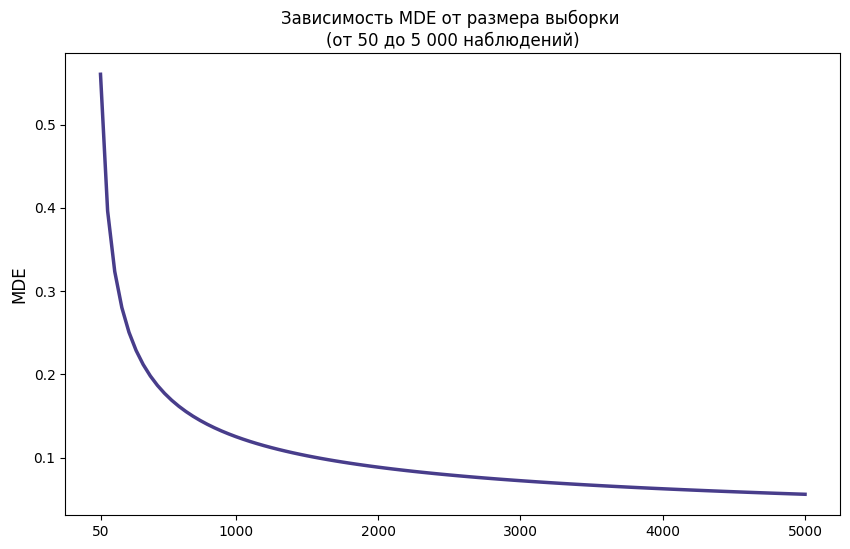

In [ ]:
sample_sizes= list(range(50, 5001, 50))
effect_sizes = [power_analysis.solve_power(nobs1=sample_size, power=power, alpha=alpha, alternative='two-sided')
                for sample_size in sample_sizes]
plt.figure(figsize=(10, 6))
ax=plt.axes()

plt.plot(sample_sizes, effect_sizes,color='darkslateblue', linewidth=2.5)
plt.title('Зависимость MDE от размера выборки \n(от 50 до 5 000 наблюдений)', fontsize='large')
plt.ylabel('MDE', fontsize='large')
ax.set_xticks([50, 1000, 2000, 3000, 4000, 5000])

plt.show()

Задаем минимальный эффект

In [ ]:
current_share = len(less_than_3)/len(metrics_df)
min_effect = 0.05
effect_size = proportion_effectsize(current_share, current_share+min_effect)

In [ ]:
sample_size = power_analysis.solve_power(effect_size, power=power, alpha=alpha, alternative='two-sided')

sample_size = math.ceil(sample_size)
sample_size

916

## A/A тест

Проверим, что выбранный метод показывает ожидаемую точность и мощность. Для этого проведём тестирование на выборках из данных до вмешательства. Ожидаем, что при альфа=0,05 в 95% случаев тест не отвергнет нулевую гипотезу об отсутствии различий.

In [ ]:
sample_size

916

In [ ]:
a_sample, b_sample = metrics_df['metric_full'].sample(sample_size), metrics_df['metric_full'].sample(sample_size)
assert len(a_sample)==len(b_sample)

In [ ]:
a = [1 if value < 3 else 0 for value in a_sample]
b = [1 if value < 3 else 0 for value in b_sample]

In [ ]:
from statsmodels.stats.proportion import proportions_ztest
count = [sum(a), sum(b)]
nobs = [len(a), len(b)]
proportions_ztest(count, nobs, alternative='larger')

(-0.3321049156077061, 0.6300949807631383)

In [ ]:
def simulate_tests(number_of_simulations):
  p_values=[]
  for i in range(number_of_simulations):
    a_sample, b_sample = metrics_df['metric_full'].sample(sample_size),  metrics_df['metric_full'].sample(sample_size)
    assert len(a_sample)==len(b_sample)
    a = [1 if value < 3 else 0 for value in a_sample]
    b = [1 if value < 3 else 0 for value in b_sample]
    count=[sum(a), sum(b)]
    nobs = [len(a), len(b)]
    z, p =proportions_ztest(count, nobs, alternative = 'larger')
    p_values.append(p)
  return p_values

In [ ]:
p_values = simulate_tests(1000)
rejections = [1 if p < 0.05 else 0 for p in p_values]  # сколько раз ошибочно отвергли H0

In [ ]:
from statsmodels.stats.proportion import proportion_confint


p_alpha = sum(rejections)/len(rejections)
ci_lower, ci_higher = proportion_confint(sum(rejections), len(rejections), alpha=0.05, method ='normal')
print(f'Число ошибок первого рода: {sum(rejections)}')
print(f'Доля ошибок первого рода (оценка вероятности такой ошибки): {p_alpha}')
print(f'ДИ для вероятности ошибки первого рода: [{round(ci_lower, 3)}; {round(ci_higher, 3)}]')

Число ошибок первого рода: 45
Доля ошибок первого рода (оценка вероятности такой ошибки): 0.045
ДИ для вероятности ошибки первого рода: [0.032; 0.058]


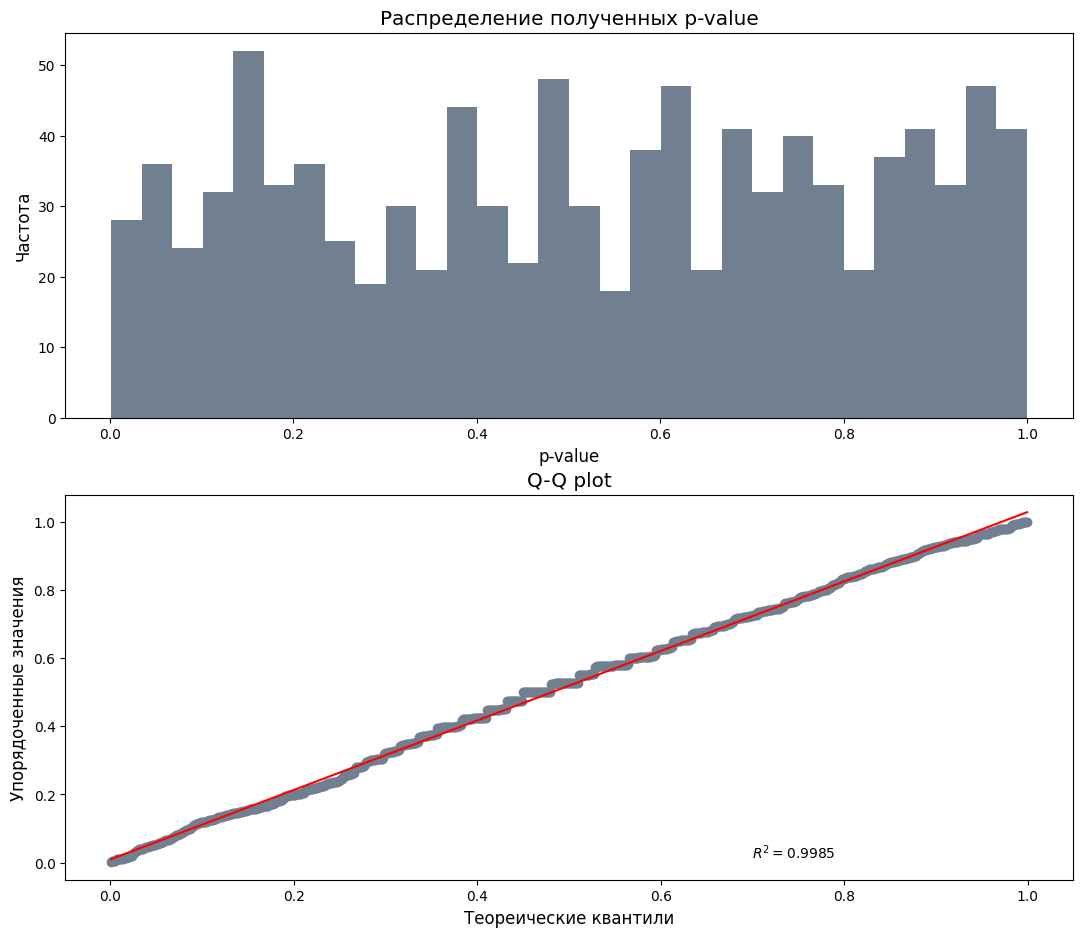

In [ ]:
#qq plot
fig=plt.figure(figsize=(13,11))
ax=fig.add_subplot(211)
plt.hist(p_values, bins=30, color='slategrey')
plt.title('Распределение полученных p-value', fontsize='x-large')
plt.xlabel('p-value', fontsize='large')
plt.ylabel('Частота', fontsize='large')
ax2=fig.add_subplot(212)
stats.probplot(p_values, dist='uniform', plot=plt, fit=True, rvalue=True)
plt.title('Q-Q plot', fontsize='x-large')
plt.xlabel('Теореические квантили', fontsize='large')
plt.ylabel('Упорядоченные значения', fontsize='large')
ax2.get_lines()[0].set_markerfacecolor('slategrey')
ax2.get_lines()[0].set_markeredgecolor('slategrey')
plt.show()

Доля ошибок первого рода находится в нужных пределах, а полученные p-value

1.   List item
2.   List item

распределены равномерно, что позволяет признать дизайн нашего теста надёжным

#Решение 2

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth

In [122]:
serps = pd.read_csv('serps.csv')


In [123]:
serps.head()

,request_id,vacancy_id_conv,city,applicant
0,168719525526659303f2dee867dc6eda,48019,Moscow,78076
1,168719525526659303f2dee867dc6eda,45120,Moscow,614859
2,168719525526659303f2dee867dc6eda,18132,Moscow,175212
3,168719525526659303f2dee867dc6eda,29942,Moscow,322643
4,168719525526659303f2dee867dc6eda,32658,Moscow,722260


In [136]:
metrics = pd.read_csv('vacs_metrics (1).csv')

In [137]:
metrics.head()

,vacancy_id_conv,metric_full,emplpyer_id
0,1,5.250818,640
1,2,5.808587,5123
2,3,2.830297,3325
3,4,5.179469,3511
4,5,5.457955,6604


2. Предобработка текста

In [127]:
serps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2431596 entries, 0 to 2431595
Data columns (total 4 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   request_id       object
 1   vacancy_id_conv  int64 
 2   city             object
 3   applicant        int64 
dtypes: int64(2), object(2)
memory usage: 74.2+ MB


In [128]:
pd.DataFrame(round(serps.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
request_id,0.000000
vacancy_id_conv,0.000000
city,0.000000
applicant,0.000000


In [131]:
serps.duplicated().sum()

0

In [132]:
serps[serps.duplicated(subset= ['request_id', 'vacancy_id_conv'],
 keep = False)]


,request_id,vacancy_id_conv,city,applicant


In [138]:
metrics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   vacancy_id_conv  55500 non-null  int64  
 1   metric_full      55500 non-null  float64
 2   emplpyer_id      55500 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 1.3 MB


In [139]:
pd.DataFrame(round(metrics.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
vacancy_id_conv,0.000000
metric_full,0.000000
emplpyer_id,0.000000


In [140]:
metrics.duplicated().sum()

0

In [144]:
metrics = metrics.rename(columns = {'emplpyer_id' : 'employer_id'})
metrics['metric_full'].describe()


count    55500.000000
mean         4.393625
std          1.430828
min         -2.259488
25%          3.609140
50%          4.562120
75%          5.372227
max          8.949871
Name: metric_full, dtype: float64

Text(0, 0.5, 'Боксплот значений метрик "скор вакансии"')

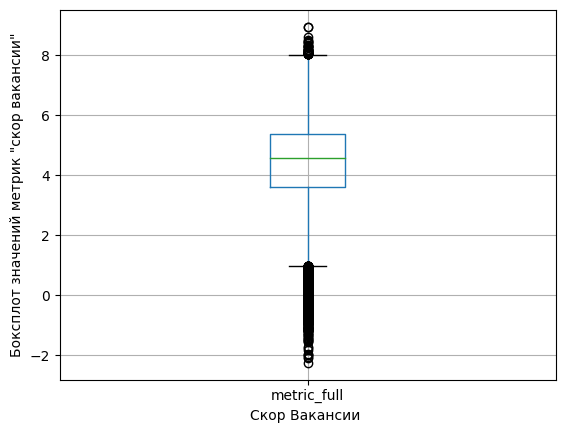

In [148]:
metrics.boxplot('metric_full')
plt.xlabel('Скор Вакансии ', fontsize=10)
plt.ylabel('Боксплот значений метрик "скор вакансии"')

array([[<Axes: title={'center': 'metric_full'}>]], dtype=object)

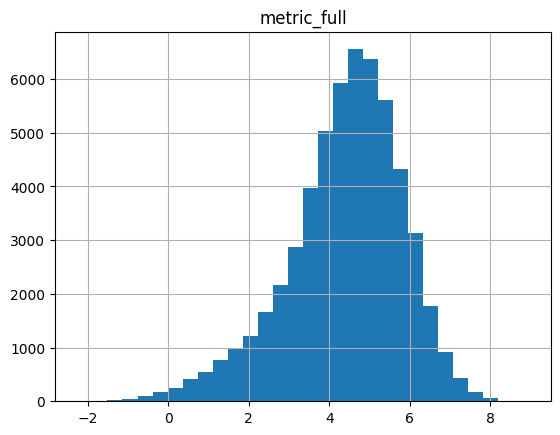

In [151]:
metrics.hist('metric_full', bins = 30)
plt.ylabel('Количество вакансий', fontsize=10)
plt.xlabel('Скор вакансии', fontsize=10)
plt.title('Распределение значений метрики "скор вакансии"')
plt.show()

Выводы по разделу:
дубликатов и пропусков не обнаружено;
медиана метрики скор составляет 4,5;
метрика скор принимает значения от -2,26 до 8,95;
распределение метрики скор скошено влево, имеется хвост вакансий с низким скором

In [155]:
df = serps.merge(metrics, how='left', on='vacancy_id_conv')
df.head()

,request_id,vacancy_id_conv,city,applicant,metric_full,employer_id
0,168719525526659303f2dee867dc6eda,48019,Moscow,78076,3.869807,4815
1,168719525526659303f2dee867dc6eda,45120,Moscow,614859,5.460877,377
2,168719525526659303f2dee867dc6eda,18132,Moscow,175212,3.836248,1063
3,168719525526659303f2dee867dc6eda,29942,Moscow,322643,4.380258,1894
4,168719525526659303f2dee867dc6eda,32658,Moscow,722260,4.741439,4902


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2431596 entries, 0 to 2431595
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   request_id       object 
 1   vacancy_id_conv  int64  
 2   city             object 
 3   applicant        int64  
 4   metric_full      float64
 5   employer_id      int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 129.9+ MB


In [157]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
request_id,0.000000
vacancy_id_conv,0.000000
city,0.000000
applicant,0.000000
metric_full,0.000000
employer_id,0.000000


3.1 Общие показатели

In [161]:
df['request_id'].nunique() #Количество запросов выдачи


1000000

In [162]:
df['applicant'].nunique() #Количество соискателей

911862

In [163]:
df['vacancy_id_conv'].nunique() #Количество вакансии

55500

In [165]:
df['employer_id'].nunique() #Количество работодателей


9961

In [164]:
df['city'].nunique() #Города

5

3.2 Относительные показатели

In [169]:
df.groupby('applicant').agg({'request_id' : pd.Series.nunique}).mean()


request_id    2.66662
dtype: float64

In [168]:
df.groupby('applicant').agg({'vacancy_id_conv' : pd.Series.nunique}).mean()


request_id    2.66662
dtype: float64

In [170]:
df_by_serp = df.groupby('request_id', as_index=False).agg({'vacancy_id_conv':'count'})
df_by_serp

,request_id,vacancy_id_conv
0,168712248514145b9ed63fc4cf33782b,1
1,16871227284706532ec66d65d92499af,1
2,168712277018061aa71a818aa9c6846f,1
3,168712288675437aaa010736bb21b50a,1
4,168712291429376e84ab68e563b66db8,1
...,...,...
999995,1687208399138f9ae5633de096324ccb,3
999996,1687208399145de1bb5b52bc19df6b8a,5
999997,168720839921108d450392c9528d9ea3,1
999998,16872083993639c8f560abf4aaabed4e,6


In [171]:
df_by_serp['vacancy_id_conv'].describe()


count    1000000.000000
mean           2.431596
std            2.290122
min            1.000000
25%            1.000000
50%            2.000000
75%            3.000000
max           50.000000
Name: vacancy_id_conv, dtype: float64

In [180]:
df_by_city = df.groupby('city').agg({'applicant': pd.Series.nunique,'request_id': pd.Series.nunique, 'employer_id':pd.Series.nunique, 'vacancy_id_conv':pd.Series.nunique, 'metric_full':['mean', 'median']})
df_by_city.columns = ['applicant_count',
 'request_count',
'employer_count',
'vacancy_count',
'metric_mean',
'metric_median']

In [191]:
df_by_city['applicant_per_vacancy'] = df_by_city['applicant_count'] / df_by_city['vacancy_count']

In [192]:
df_by_city = df_by_city.sort_values('applicant_count')
df_by_city

,applicant_count,request_count,employer_count,vacancy_count,metric_mean,metric_median,applicant_per_vacancy
city,,,,,,,
Samara,220392,200000,9767,37049,4.978616,5.000377,5.948663
Penza,293710,200000,9861,41881,4.932389,4.947076,7.012965
Kazan,366458,200000,9899,45220,4.912606,4.933001,8.103892
SPb,446735,200000,9915,47864,4.895742,4.924641,9.333424
Moscow,544221,200000,9931,50169,4.880055,4.914729,10.847755


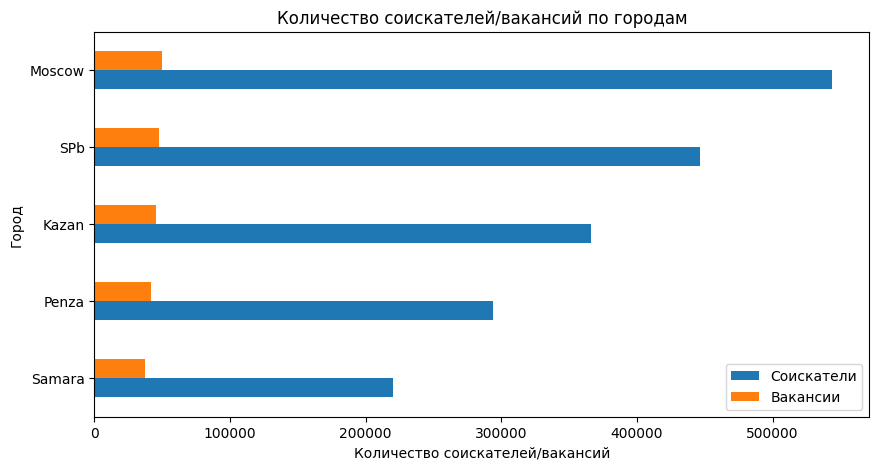

In [193]:
df_by_city[['applicant_count', 'vacancy_count']].plot.barh(figsize=(10, 5))
plt.xlabel('Количество соискателей/вакансий')
plt.ylabel('Город')
plt.title('Количество соискателей/вакансий по городам')
plt.legend(title='Количество', title_fontsize = 10, prop ={'size':10})
plt.legend(['Соискатели', 'Вакансии'])
plt.show()

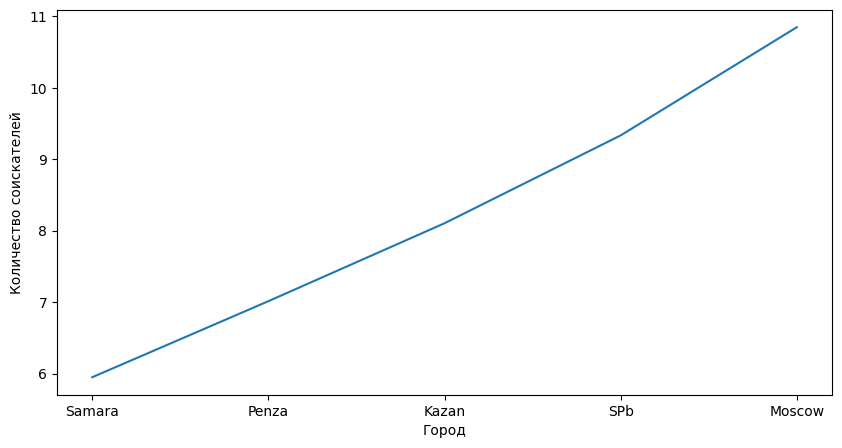

In [195]:
plt.figure(figsize=(10, 5))
plt.plot(df_by_city['applicant_per_vacancy'])
plt.xlabel('Город')
plt.ylabel('Количество соискателей')
plt.show()

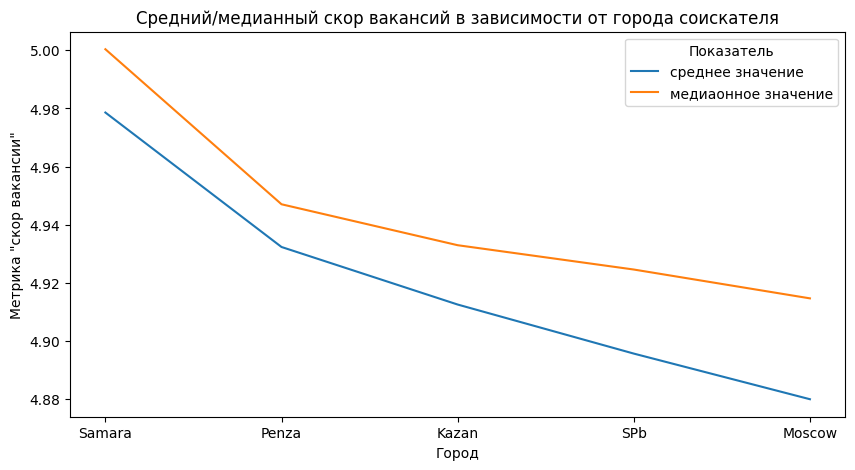

In [197]:
plt.figure(figsize=(10, 5))
plt.plot(df_by_city['metric_mean'], label='среднее значение')
plt.plot(df_by_city['metric_median'], label='медиаонное значение')
plt.ylabel('Метрика "скор вакансии"')
plt.xlabel('Город')
plt.title('Средний/медианный скор вакансий в зависимости от города соискателя')
plt.legend(title= 'Показатель', title_fontsize = 10, prop = {'size' : 10})
plt.show()

Расчет доли где скор меньше 3

In [199]:
vacancy_count_total = metrics['vacancy_id_conv'].nunique()
vacancy_count_total

55500

In [201]:
vacancy_lower_goal=metrics[metrics['metric_full'] < 3]['vacancy_id_conv'].count()
vacancy_lower_goal

8499

In [202]:
rate = vacancy_lower_goal/vacancy_count_total*100
rate

15.313513513513513